# Backtesting Pure Mean Reversion Strategy

Suppose all trading periods are mean reversion:

Mean Reversion Strategy:

     1.If return in the past 21 days > 0.02, we sell     
     2.If return in the past 21 days < -0.02, we buy     
     3.We close the position every 10 days 




In [2]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

import pandas as pd
from datetime import datetime

In [3]:

class RSI_Oversold(bt.Indicator):
    lines = ('oversold',)
    
    params = (
        ('level', 30),    
    )

    def __init__(self):
        self.lines.oversold = bt.indicators.RSI(self.data) < self.p.level

        
class DummyInd(bt.Indicator):
    lines = ('dummyline',)

    params = (('value', 5),)

    def __init__(self):
        self.lines.dummyline = bt.Max(0.0, self.params.value)

        
# Create a Stratey
class BackTradingStrategy(bt.Strategy):
    params = (
        ('period', 128),
        ("max_days_in_trade", 10)
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
        
    def read_signals(self):
        signal_data = pd.read_csv("hmm_regime_signals.csv")
        signal_data["datetime"] = signal_data["datetime"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y"))

        signal_data = signal_data.set_index('datetime')
        
        """
        start_date = '2013-02-11'
        end_date = '2018-02-09'
        signals = signal_data['state'].loc[start_date:end_date]               
        dt = self.datadate(0).strftime('%Y-%m-%d')
        #print(signal_data.iloc[0])
        print(signal_data['state'].loc[dt])
        """
        
        return signal_data
        

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.dataopen = self.datas[0].open
        self.datadate = self.datas[0].datetime.date
        self.days_in_trade = 0
        self.max_days_in_trade_mr = 10
        self.max_days_in_trade_mo = 21
        self.num_mr = 21
        self.num_mo = 21*6
        self.regime_state = 0
        self.mrr = 0.02
        self.mor = 0.05
        #self.signal_data = self.read_signals()
        self.signals = [1]*1260
        self.counter = 0
        

        
    def stock_return(self, n):
        """calculate return in the past n days """        
        r = (self.dataclose[0] - self.dataclose[-n+1])/self.dataclose[-n+1]
        return r   
    

    def next(self):
        # Simply log the closing price of the series from the reference
        
        self.log('Close, %.2f' % self.dataclose[0])        
        
        dt = self.datadate(0).strftime('%Y-%m-%d')
        
        signal = self.signals[self.counter]
        
        self.counter += 1
        
        # Check if we are in the market
        if not self.position:
            # if we do not have a position
            
            if signal == 1:
                # mean reversion
                # we BUY if return in the past num_mr days is less than -mrr
                
                r = self.stock_return(self.num_mr)
                
                if (r < - self.mrr):
                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()
                    
                    self.days_in_trade = 1
                    
                    self.regime_state = 1
                    
                    
                # we SELL if return in the past num_mr days is more than mrr    
                elif (r > self.mrr):                

                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell()
                    
                    self.days_in_trade = 1
                    
                    self.regime_state = 1
            
            else:
                # momentum
                # we SELL if return in the past num_mr days is less than -mrr
                
                r = self.stock_return(self.num_mo)
                
                if (r < - self.mor):
                    # SELL, SELL, SELL!!! (with all possible default parameters)
                    self.log('SELL CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.sell()
                    
                    self.days_in_trade = 1
                    
                    self.regime_state = 0
                    
                # we SELL if return in the past num_mr days is more than mrr    
                elif (r > self.mor):                

                    # BUY, BUY, BUY!!! (with all possible default parameters)
                    self.log('BUY CREATE, %.2f' % self.dataclose[0])

                    # Keep track of the created order to avoid a 2nd order
                    self.order = self.buy()
                    
                    self.days_in_trade = 1
                    
                    self.regime_state = 0
                
            

        else:
            # if we have a position
            
            self.days_in_trade += 1
            
            # mean reversion
            if (self.regime_state == 1):
            
                # close the position if regime shift or after holding it for max_mr days.
                if signal == 0 or self.days_in_trade == self.max_days_in_trade_mr:
                    
                    if self.position.size > 0:
                        # SELL to close position
                        self.log('Close poition---SELL EMPTY, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.sell()
                
                    else:
                        # BUY to close position 
                        self.log('Close poition---BUY EMPTY, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()
            
            
            # momentum
            if (self.regime_state == 0):
                
                # close the position if regime shift or after holding it for max_mo days.
                if signal == 1 or self.days_in_trade == self.max_days_in_trade_mo:
                    
                    if self.position.size > 0:
                        # SELL to close position
                        self.log('Close poition---SELL EMPTY, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.sell()
                
                    else:
                        # BUY to close position 
                        self.log('Close poition---BUY EMPTY, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()
                 
       


In [4]:


if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(BackTradingStrategy)

    datapath = os.path.join('../../../datas/spx-2013-2018.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        #fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        #todate=datetime.datetime(2018, 2, 9),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)
    
    

    # Write output
    cerebro.addwriter(bt.WriterFile, out='pure_mean_reversion.csv',csv=True)
    
    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2013-02-11, Close, 1517.01
2013-02-11, BUY CREATE, 1517.01
2013-02-12, Close, 1519.43
2013-02-13, Close, 1520.33
2013-02-14, Close, 1521.38
2013-02-15, Close, 1519.79
2013-02-19, Close, 1530.94
2013-02-20, Close, 1511.95
2013-02-21, Close, 1502.42
2013-02-22, Close, 1515.60
2013-02-25, Close, 1487.85
2013-02-25, Close poition---SELL EMPTY, 1487.85
2013-02-26, Close, 1496.94
2013-02-26, BUY CREATE, 1496.94
2013-02-27, Close, 1515.99
2013-02-28, Close, 1514.68
2013-03-01, Close, 1518.20
2013-03-04, Close, 1525.20
2013-03-05, Close, 1539.79
2013-03-06, Close, 1541.46
2013-03-07, Close, 1544.26
2013-03-08, Close, 1551.18
2013-03-11, Close, 1556.22
2013-03-11, Close poition---SELL EMPTY, 1556.22
2013-03-12, Close, 1552.48
2013-03-12, SELL CREATE, 1552.48
2013-03-13, Close, 1554.52
2013-03-14, Close, 1563.23
2013-03-15, Close, 1560.70
2013-03-18, Close, 1552.10
2013-03-19, Close, 1548.34
2013-03-20, Close, 1558.71
2013-03-21, Close, 1545.80
2013-03-22, Clo

In [5]:
# calculate pnl using excel data
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('pure_mean_reversion.csv').fillna(value = 0)
data = data[:1260]

df = data[['datetime', 'pnlplus', 'pnlminus']].copy()
n = len(df)

df['cumulative_pnl'] = df['pnlplus']

cpnl = 0.
count_plus = 0
count_minus = 0

for i in range(n):
    plus = df['pnlplus'].iloc[i]
    minus = df['pnlminus'].iloc[i]
    cpnl = cpnl + plus + minus
    df['cumulative_pnl'].iloc[i] = cpnl
    
    if (plus > 0.):
        count_plus +=1
    if (minus < 0.):
        count_minus +=1

    

/home/project/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
plus_percent = 1.0*count_plus/(count_plus*1.0+count_minus*1.0) 
print('percentage of trading that make positive profits = ', plus_percent)

percentage of trading that make positive profits =  0.4673913043478261


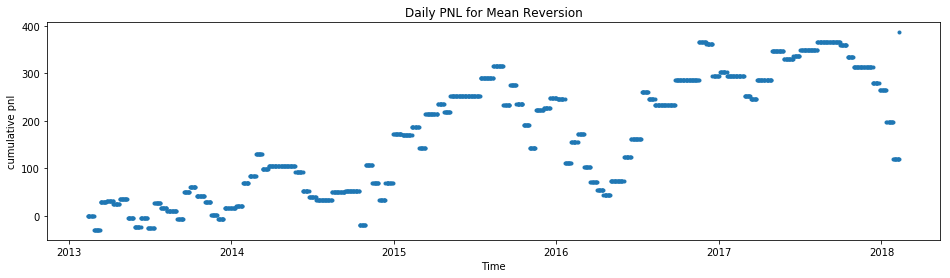

In [7]:
# convert string to datetime
df["datetime"] = df["datetime"].apply(lambda x: datetime.strptime(x,"%Y-%m-%d %H:%M:%S.%f"))

# plot PNL figures 
plt.figure(figsize=(16, 4))
plt.plot(df['datetime'], df['cumulative_pnl'] ,'.') 
plt.xlabel("Time")
plt.ylabel("cumulative pnl")
plt.title("Daily PNL for Mean Reversion")
plt.show()